In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import resnet18, resnet50
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
import torch.nn.functional as F
import math
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 1

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/imagenetmini-1000/imagenet-mini/val', transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

model = models.shufflenet_v2_x0_5(pretrained=True)  # Use pretrained weights on ImageNet-1k

model = model.to(device)

model.eval()

num_images = len(test_dataset)  # Get the number of images
print(f'Number of images in the validation folder: {num_images}')

values = np.linspace(0, 1, 16)
thresholds = [round(i, 4) for i in values]

print(thresholds)
num_thresholds = len(thresholds)

def quantize_to_8bit(probabilities):
    # Ensure probabilities are in the [0, 1] range
    probabilities = torch.clamp(probabilities, 0, 1)
    
    # Scale probabilities to 255 intervals, round to the nearest one, and then scale back
    quantized = torch.round(probabilities * 15) / 15
    
    return quantized


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 90.9MB/s]


Number of images in the validation folder: 3923
[0.0, 0.0667, 0.1333, 0.2, 0.2667, 0.3333, 0.4, 0.4667, 0.5333, 0.6, 0.6667, 0.7333, 0.8, 0.8667, 0.9333, 1.0]


In [3]:
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 60.64%


In [4]:
print(correct, incorrect, total)

2379 1544 3923


In [5]:
# Algorithm - All offload
cost_all_offload = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    # Calculate the cost for all offload
    temp = round(alpha * num_images, 2)
    cost_all_offload.append(temp)
    
print(f"Cost for all offload Algorithm with increasing alpha: {cost_all_offload}")

Cost for all offload Algorithm with increasing alpha: [0.0, 392.3, 784.6, 1176.9, 1569.2, 1961.5, 2353.8, 2746.1, 3138.4, 3530.7, 3923.0]


In [6]:
# Algorithm - No offload
number_of_incorrectly_classified_images = incorrect
cost_no_offload = [number_of_incorrectly_classified_images]*11
print(number_of_incorrectly_classified_images)
print(f"Cost for no offload Algorithm is: {cost_no_offload}")

1544
Cost for no offload Algorithm is: [1544, 1544, 1544, 1544, 1544, 1544, 1544, 1544, 1544, 1544, 1544]


In [7]:
# Algorithm - Offline optimal
cost_offline_optimal = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_current_alpha = 0.0  # Reset cost for each alpha

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            # Calculate cost based on prediction accuracy
            if pred_class != true_class:
                cost_current_alpha += alpha  # Increment cost by alpha for incorrect predictions

    # Store the calculated cost for the current alpha in the list
    cost_offline_optimal.append(cost_current_alpha)

# Print the list of costs for offline optimal algorithm
print(f"Cost for offline optimal Algorithm is: {cost_offline_optimal}")


Cost for offline optimal Algorithm is: [0.0, 154.8999999999955, 309.799999999991, 464.70000000001187, 619.599999999982, 774.5, 929.4000000000237, 1084.3000000000313, 1239.199999999964, 1394.1000000000192, 1549.0]


In [8]:
# Algorithm - LCB UCB algorithm
delta = 1/math.e

# List to store costs for each alpha
cost_LCB_UCB_list = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_LCB_UCB = 0.0  # Reset cost for each alpha

    # Initialize or reset dictionaries for each alpha iteration
    dict = {
        'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
        'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
        'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
        'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
    }
    
    correct_counts = {threshold: 0 for threshold in thresholds}
    offloads_counts = {threshold: 0 for threshold in thresholds}
    total_counts = {threshold: 0 for threshold in thresholds}

    # Process each batch of images
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)
            pred_class = predicted_labels.item()
            true_class = labels.item()

            total_counts[pred_probs] += 1

            # Apply the LCB UCB conditions
            if dict['LCB'][pred_probs] >= (1 - alpha):
                if pred_class == true_class:
                    cost_LCB_UCB += 0
                else:
                    cost_LCB_UCB += 1

            elif dict['UCB'][pred_probs] <= (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            log_delta = math.log(1 / delta)
            uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

            dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
            dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

            # Update bounds for each threshold
            for x1 in thresholds:
                if x1 <= pred_probs:
                    for x in thresholds:
                        if x1 <= x <= pred_probs:
                            dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

            for x2 in thresholds:
                if x2 >= pred_probs:
                    for x in thresholds:
                        if x2 >= x >= pred_probs:
                            dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

    # Store the cost for the current alpha value in the list
    cost_LCB_UCB_list.append(cost_LCB_UCB)

# Print the entire list of costs for each alpha
print("Cost values for each alpha:", cost_LCB_UCB_list)


Cost values for each alpha: [0.0, 351.1000000000103, 633.2000000000048, 869.5999999999692, 1087.199999999975, 1246.0, 1390.199999999982, 1502.1000000000304, 1551.1999999999791, 1586.7000000000044, 1549.0]


In [8]:
# # Algorithm - LCB UCB algorithm
# delta = 1/(total)**2.5

# # List to store costs for each alpha
# cost_LCB_UCB_list = []

# # Iterate over alpha values from 0 to 1 with an increment of 0.1
# for alpha in [round(i * 0.1, 1) for i in range(11)]:
#     cost_LCB_UCB = 0.0  # Reset cost for each alpha
#     image_count = 1

#     # Initialize or reset dictionaries for each alpha iteration
#     dict = {
#         'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
#         'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
#         'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
#         'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
#     }
    
#     correct_counts = {threshold: 0 for threshold in thresholds}
#     offloads_counts = {threshold: 0 for threshold in thresholds}
#     total_counts = {threshold: 0 for threshold in thresholds}

#     # Process each batch of images
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get model outputs and softmax probabilities
#             outputs = model(images)
#             softmax_probs = F.softmax(outputs, dim=1)

#             # Quantize probabilities to 8-bit
#             quantized_probs = quantize_to_8bit(softmax_probs)

#             # Get the predicted probabilities and classes
#             predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#             pred_probs = round(predicted_probs.item(), 4)
#             pred_class = predicted_labels.item()
#             true_class = labels.item()

#             total_counts[pred_probs] += 1

#             # Apply the LCB UCB conditions
#             if dict['LCB'][pred_probs] >= (1 - alpha):
#                 if pred_class == true_class:
#                     cost_LCB_UCB += 0
#                 else:
#                     cost_LCB_UCB += 1

#             elif dict['UCB'][pred_probs] <= (1 - alpha):
#                 dict['Tx'][pred_probs] += 1
#                 if pred_class == true_class:
#                     correct_counts[pred_probs] += 1
#                 dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
#                 offloads_counts[pred_probs] += 1
#                 cost_LCB_UCB += alpha

#             elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
#                 dict['Tx'][pred_probs] += 1
#                 if pred_class == true_class:
#                     correct_counts[pred_probs] += 1
#                 dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
#                 offloads_counts[pred_probs] += 1
#                 cost_LCB_UCB += alpha

#             log_delta = math.log(1 / delta)
#             uncertainty = 1/4.54*math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

#             dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
#             dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

#             # Update bounds for each threshold
#             for x1 in thresholds:
#                 if x1 <= pred_probs:
#                     for x in thresholds:
#                         if x1 <= x <= pred_probs:
#                             dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

#             for x2 in thresholds:
#                 if x2 >= pred_probs:
#                     for x in thresholds:
#                         if x2 >= x >= pred_probs:
#                             dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

#             image_count += 1

#     # Store the cost for the current alpha value in the list
#     cost_LCB_UCB_list.append(cost_LCB_UCB)

# # Print the entire list of costs for each alpha
# print("Cost values for each alpha:", cost_LCB_UCB_list)


Cost values for each alpha: [0.0, 360.7000000000108, 641.0000000000068, 861.6999999999684, 1122.799999999991, 1249.0, 1391.5999999999897, 1492.300000000026, 1565.9999999999786, 1590.5000000000066, 1549.0]


In [4]:
# total = 3924

In [6]:
# # Algorithm - LCB UCB algorithm
# delta = 1/(total)**2.5

# # List to store costs for each alpha
# cost_LCB_UCB_list = []

# # Iterate over alpha values from 0 to 1 with an increment of 0.1
# for alpha in [round(i * 0.1, 1) for i in range(11)]:
#     cost_LCB_UCB = 0.0  # Reset cost for each alpha
#     image_count = 1

#     # Initialize or reset dictionaries for each alpha iteration
#     dict = {
#         'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
#         'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
#         'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
#         'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
#     }
    
#     correct_counts = {threshold: 0 for threshold in thresholds}
#     offloads_counts = {threshold: 0 for threshold in thresholds}
#     total_counts = {threshold: 0 for threshold in thresholds}

#     # Process each batch of images
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get model outputs and softmax probabilities
#             outputs = model(images)
#             softmax_probs = F.softmax(outputs, dim=1)

#             # Quantize probabilities to 8-bit
#             quantized_probs = quantize_to_8bit(softmax_probs)

#             # Get the predicted probabilities and classes
#             predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#             pred_probs = round(predicted_probs.item(), 4)
#             pred_class = predicted_labels.item()
#             true_class = labels.item()

#             total_counts[pred_probs] += 1

#             # Apply the LCB UCB conditions
#             if dict['LCB'][pred_probs] >= (1 - alpha):
#                 if pred_class == true_class:
#                     cost_LCB_UCB += 0
#                 else:
#                     cost_LCB_UCB += 1

#             elif dict['UCB'][pred_probs] <= (1 - alpha):
#                 dict['Tx'][pred_probs] += 1
#                 if pred_class == true_class:
#                     correct_counts[pred_probs] += 1
#                 dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
#                 offloads_counts[pred_probs] += 1
#                 cost_LCB_UCB += alpha

#             elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
#                 dict['Tx'][pred_probs] += 1
#                 if pred_class == true_class:
#                     correct_counts[pred_probs] += 1
#                 dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
#                 offloads_counts[pred_probs] += 1
#                 cost_LCB_UCB += alpha

#             log_delta = math.log(1 / delta)
#             uncertainty = 1/2.13*math.pow(log_delta / (dict['Tx'][pred_probs]),1/4) if dict['Tx'][pred_probs] > 0 else 1.0

#             dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
#             dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

#             # Update bounds for each threshold
#             for x1 in thresholds:
#                 if x1 <= pred_probs:
#                     for x in thresholds:
#                         if x1 <= x <= pred_probs:
#                             dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

#             for x2 in thresholds:
#                 if x2 >= pred_probs:
#                     for x in thresholds:
#                         if x2 >= x >= pred_probs:
#                             dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

#             image_count += 1

#     # Store the cost for the current alpha value in the list
#     cost_LCB_UCB_list.append(cost_LCB_UCB)

# # Print the entire list of costs for each alpha
# print("Cost values for each alpha:", cost_LCB_UCB_list)


Cost values for each alpha: [0.0, 392.3000000000207, 784.6000000000414, 1007.1999999999412, 1210.4, 1352.0, 1576.7999999999518, 1668.9000000000556, 1588.1999999999746, 1776.800000000033, 1549.0]


In [9]:
# Algorithm - LCB UCB without structural information
delta = 1 / math.e

# List to store costs for each alpha
cost_no_info_list = []

for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_no_info = 0.0  # Reset cost for each alpha

    dict = {
        'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
        'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
        'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
        'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
    }

    correct_counts = {threshold: 0 for threshold in thresholds}
    offloads_counts = {threshold: 0 for threshold in thresholds}
    total_counts = {threshold: 0 for threshold in thresholds}

    count = 1  # Initialize image counter

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            total_counts[pred_probs] += 1

            # Apply the LCB UCB conditions
            if dict['LCB'][pred_probs] >= (1 - alpha):
                if pred_class != true_class:
                    cost_no_info += 1

            elif dict['UCB'][pred_probs] <= (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_no_info += alpha

            elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_no_info += alpha

            log_delta = math.log(1 / delta)
            uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

            dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
            dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

    # Store the cost for the current alpha value in the list
    cost_no_info_list.append(cost_no_info)

# Print the entire list of costs for each alpha
print("Cost values for each alpha:", cost_no_info_list)


Cost values for each alpha: [0.0, 360.60000000001054, 639.8000000000079, 867.6999999999665, 1086.7999999999781, 1258.5, 1397.9999999999866, 1499.0000000000186, 1558.3999999999799, 1597.400000000003, 1549.0]


In [10]:
# Algorithm - LCB UCB algorithm
delta = 1/math.e

# List to store costs for each alpha
cost_LCB_UCBh_list = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_LCB_UCB = 0.0  # Reset cost for each alpha

    # Initialize or reset dictionaries for each alpha iteration
    dict = {
        'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
        'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
        'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
        'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
    }
    
    correct_counts = {threshold: 0 for threshold in thresholds}
    offloads_counts = {threshold: 0 for threshold in thresholds}
    total_counts = {threshold: 0 for threshold in thresholds}

    # Process each batch of images
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)
            pred_class = predicted_labels.item()
            true_class = labels.item()

            total_counts[pred_probs] += 1

            # Apply the LCB UCB conditions
            if dict['LCB'][pred_probs] >= (1 - alpha):
                if pred_class == true_class:
                    cost_LCB_UCB += 0
                else:
                    cost_LCB_UCB += 1

            elif dict['UCB'][pred_probs] <= (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            log_delta = math.log(1 / delta)
            uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

            dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
            dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

            
            eta = max(0.2, min(0.25, uncertainty))  # Dynamically adjust epsilon
    
            for x1 in thresholds:
                if x1 <= pred_probs:
                    for x in thresholds:
                        if x1 <= x and x <= pred_probs:
                            if uncertainty < eta:
                                dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])
    
            for x2 in thresholds:
                if x2 >= pred_probs:
                    for x in thresholds:
                        if x2 >= x and x >= pred_probs:
                            if uncertainty < eta:
                                dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])
    
        # Store the cost for the current alpha value in the list
        cost_LCB_UCBh_list.append(cost_LCB_UCB)

# Print the entire list of costs for each alpha
print("Cost values for each alpha:", cost_LCB_UCBh_list)


Cost values for each alpha: [0.0, 357.200000000012, 638.6000000000083, 866.1999999999664, 1081.1999999999773, 1252.0, 1407.7999999999893, 1503.9000000000258, 1557.3999999999799, 1597.9000000000058, 1549.0]


In [11]:
print(dict['Tx'])

{0.0: 0, 0.0667: 0, 0.1333: 0, 0.2: 0, 0.2667: 0, 0.3333: 0, 0.4: 0, 0.4667: 0, 0.5333: 0, 0.6: 0, 0.6667: 0, 0.7333: 0, 0.8: 0, 0.8667: 0, 0.9333: 0, 1.0: 0}


In [12]:
print(total_counts)

{0.0: 1, 0.0667: 55, 0.1333: 181, 0.2: 223, 0.2667: 225, 0.3333: 207, 0.4: 213, 0.4667: 214, 0.5333: 226, 0.6: 202, 0.6667: 186, 0.7333: 165, 0.8: 204, 0.8667: 244, 0.9333: 387, 1.0: 990}


In [13]:
# Algorithm - Hedge
def choose_threshold(weights, thresholds, W_t):
    # Create probability distribution for selecting a threshold
    probabilities = np.array([weights[theta] / W_t for theta in thresholds])
    
    # Choose a threshold based on the weight distribution
    chosen_threshold_idx = np.random.choice(len(thresholds), p=probabilities)
    chosen_threshold = thresholds[chosen_threshold_idx]
    
    return chosen_threshold

cost_hedge_list = []

# Iterate over different values of alpha
for alpha in np.arange(0, 1.1, 0.1):
    η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
    ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

    cost_hedge = 0.0
    weights = {threshold: 1.0 for threshold in thresholds}  # Initialize weights for each threshold
    W_t = sum(weights.values())  # Sum the initial weights to get W_t
    incorrect_count = {threshold: 0 for threshold in thresholds}
    correct_count = {threshold: 0 for threshold in thresholds}
    offload_count = {threshold: 0 for threshold in thresholds}
    total_count = {threshold: 0 for threshold in thresholds}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            p_t = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            # Choose a threshold based on the current weights
            chosen_threshold = choose_threshold(weights, thresholds, W_t)

            total_count[p_t] += 1

            if p_t < chosen_threshold:
                offload_count[p_t] += 1
                cost_hedge += alpha  # Offload, cost is alpha
            else:
                if pred_class != true_class:
                    incorrect_count[p_t] += 1
                    cost_hedge += 1  # Incorrect prediction, full cost
                else:
                    correct_count[p_t] += 1

            # Compute pseudo-loss and update weights
            if pred_class == true_class:
                Y_t = 0
            else:
                Y_t = 1

            for threshold in thresholds:
                if p_t < threshold:
                    pseudo_loss = alpha  # Offload cost
                else:
                    pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Loss depends on epsilon

                # Update the weight for the current threshold
                weights[threshold] = weights[threshold] * np.exp(-η * pseudo_loss)

            # Recalculate W_t as the sum of all updated weights
            W_t = sum(weights.values())

    cost_hedge_list.append(cost_hedge)

print(cost_hedge_list)


[155.0, 398.60000000001787, 666.2000000000126, 937.89999999997, 1102.5999999999856, 1287.0, 1439.7999999999822, 1500.400000000016, 1555.7999999999922, 1598.7000000000019, 1601.0]


In [14]:
# # Algorithm - Loss_LCB
# alpha_results_1 = []

# for alpha in np.arange(0, 1.1, 0.1):  # alpha from 0 to 1 with step of 0.1
#     loss_hat = {threshold: 0.0 for threshold in thresholds}
#     T_x = {threshold: 0 for threshold in thresholds}

#     cost_loss_LCB = 0.0
#     η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
#     ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

#     offload_count = {threshold: 0 for threshold in thresholds}
#     incorrect_count = {threshold: 0 for threshold in thresholds}
#     correct_count = {threshold: 0 for threshold in thresholds}

#     image_count = 1

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get model outputs and softmax probabilities
#             outputs = model(images)
#             softmax_probs = F.softmax(outputs, dim=1)

#             # Quantize probabilities to 8-bit
#             quantized_probs = quantize_to_8bit(softmax_probs)

#             # Get the predicted probabilities and classes
#             predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#             pred_probs = round(predicted_probs.item(), 4)
#             pred_class = predicted_labels.item()
#             true_class = labels.item()

#             best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t] - math.log(math.e / (T_x[t] + 1e-8))))

#             if pred_probs < best_threshold:
#                 offload_count[best_threshold] += 1
#                 cost_loss_LCB += alpha  # Offload, cost is alpha
#             else:
#                 if pred_class != true_class:
#                     incorrect_count[best_threshold] += 1
#                     cost_loss_LCB += 1  # Incorrect prediction, full cost
#                 else:
#                     correct_count[best_threshold] += 1

#             T_x[best_threshold] += 1

#             Y_t = 0 if pred_class == true_class else 1

#             for threshold in thresholds:
#                 if pred_probs < threshold:
#                     pseudo_loss = alpha  # Offload cost
#                 else:
#                     pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

#                 loss_hat[threshold] += pseudo_loss

#             image_count += 1

#     alpha_results_1.append(cost_loss_LCB)

# print(alpha_results_1)

[52.0, 345.90000000001027, 622.8000000000036, 876.2999999999689, 1089.7999999999863, 1267.5, 1427.1999999999862, 1508.9000000000085, 1526.3999999999896, 1593.8000000000116, 1555.0]


In [15]:
# # Algorithm - Loss
# alpha_results_2 = []

# for alpha in np.arange(0, 1.1, 0.1):  # alpha from 0 to 1 with step of 0.1
#     loss_hat = {threshold: 0.0 for threshold in thresholds}
#     T_x = {threshold: 0 for threshold in thresholds}

#     cost_loss_LCB = 0.0
#     η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
#     ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

#     offload_count = {threshold: 0 for threshold in thresholds}
#     incorrect_count = {threshold: 0 for threshold in thresholds}
#     correct_count = {threshold: 0 for threshold in thresholds}

#     image_count = 1

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get model outputs and softmax probabilities
#             outputs = model(images)
#             softmax_probs = F.softmax(outputs, dim=1)

#             # Quantize probabilities to 8-bit
#             quantized_probs = quantize_to_8bit(softmax_probs)

#             # Get the predicted probabilities and classes
#             predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#             pred_probs = round(predicted_probs.item(), 4)
#             pred_class = predicted_labels.item()
#             true_class = labels.item()

#             best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t]))

#             if pred_probs < best_threshold:
#                 offload_count[best_threshold] += 1
#                 cost_loss_LCB += alpha  # Offload, cost is alpha
#             else:
#                 if pred_class != true_class:
#                     incorrect_count[best_threshold] += 1
#                     cost_loss_LCB += 1  # Incorrect prediction, full cost
#                 else:
#                     correct_count[best_threshold] += 1

#             T_x[best_threshold] += 1

#             Y_t = 0 if pred_class == true_class else 1

#             for threshold in thresholds:
#                 if pred_probs < threshold:
#                     pseudo_loss = alpha  # Offload cost
#                 else:
#                     pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

#                 loss_hat[threshold] += pseudo_loss

#             image_count += 1

#     alpha_results_2.append(cost_loss_LCB)

# print(alpha_results_2)

[51.0, 354.1000000000111, 628.8000000000038, 890.7999999999685, 1063.9999999999748, 1329.0, 1364.399999999988, 1541.1000000000015, 1534.3999999999949, 1555.4000000000008, 1553.0]


In [14]:
print(cost_offline_optimal)

[0.0, 154.8999999999955, 309.799999999991, 464.70000000001187, 619.599999999982, 774.5, 929.4000000000237, 1084.3000000000313, 1239.199999999964, 1394.1000000000192, 1549.0]


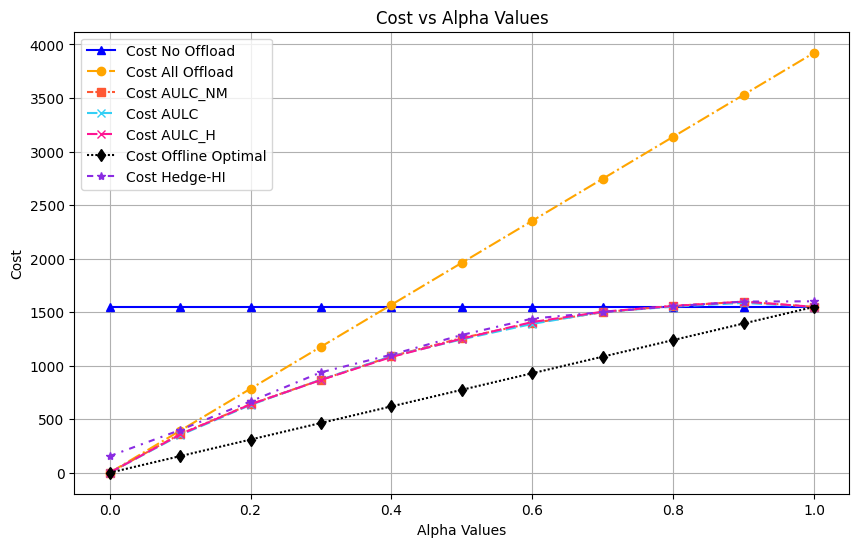

In [15]:
import matplotlib.pyplot as plt

# Alpha values
alpha_values = [round(i * 0.1, 1) for i in range(11)]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(alpha_values, cost_no_offload, linestyle='-', marker='^', label='Cost No Offload', color='blue')
plt.plot(alpha_values, cost_all_offload, linestyle='-.', marker='o', label='Cost All Offload', color='orange')
plt.plot(alpha_values, cost_no_info_list, linestyle=(0, (3, 1, 1, 1)), marker='s', label='Cost AULC_NM', color='#FF5733')  # Dashed-dot-dot style
plt.plot(alpha_values, cost_LCB_UCB_list, linestyle=(0, (5, 2)), marker='x', label='Cost AULC', color='#33CFF5')  # Longer dashes
plt.plot(alpha_values, cost_LCB_UCBh_list, linestyle=(0, (5, 2)), marker='x', label='Cost AULC_H', color='#FF1493')  # Longer dashes
plt.plot(alpha_values, cost_offline_optimal, linestyle=(0, (1, 1)), marker='d', label='Cost Offline Optimal', color='black')  # Dense dotted style
plt.plot(alpha_values, cost_hedge_list, linestyle=(0, (3, 3, 1, 3)), marker='*', label='Cost Hedge-HI', color='#8A2BE2')  # Dash-dot-dash style
# plt.plot(alpha_values, alpha_results_1, linestyle='-', marker='x', label='Loss LCB', color='#FF1493')  # Solid bright pink
# plt.plot(alpha_values, alpha_results_2, linestyle=(0, (5, 1)), marker='o', label='Loss', color='#32CD32')  # Dense dashed bright green

# Adding labels and title
plt.xlabel('Alpha Values')
plt.ylabel('Cost')
plt.title('Cost vs Alpha Values')
plt.legend()
plt.grid()

# Show plot
plt.show()


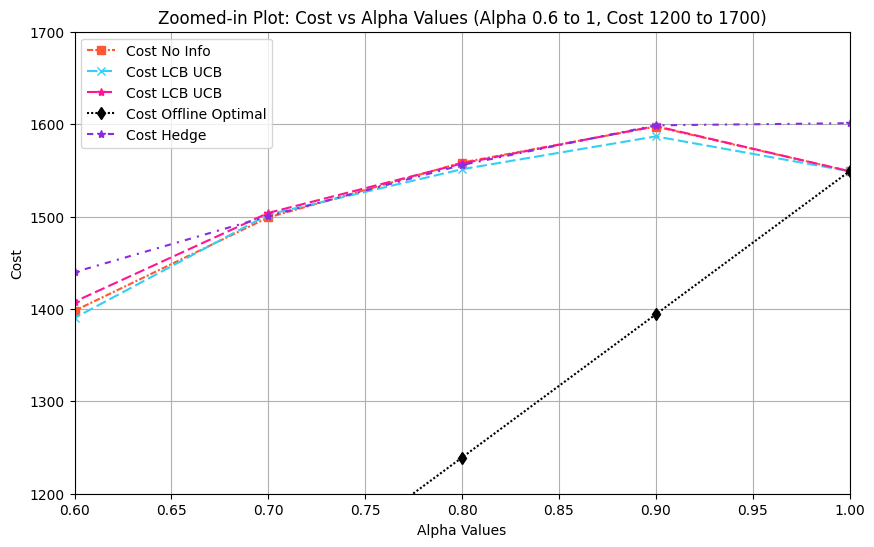

In [3]:
# Create a zoomed-in plot for the region of interest (alpha: 0.8 to 1, cost: 1000 to 2000)
plt.figure(figsize=(10, 6))

# Plot the same data for the zoomed-in region
# plt.plot(alpha_values, cost_no_offload, linestyle='-', marker='^', label='Cost No Offload', color='blue')
# plt.plot(alpha_values, cost_all_offload, linestyle='-.', marker='o', label='Cost All Offload', color='orange')
plt.plot(alpha_values, cost_no_info_list, linestyle=(0, (3, 1, 1, 1)), marker='s', label='Cost No Info', color='#FF5733')  # Dashed-dot-dot style
plt.plot(alpha_values, cost_LCB_UCB_list, linestyle=(0, (5, 2)), marker='x', label='Cost LCB UCB', color='#33CFF5')  # Longer dashes
plt.plot(alpha_values, cost_LCB_UCBh_list, linestyle=(0, (5, 2)), marker='*', label='Cost LCB UCB', color='#FF1493')  # Longer dashes
plt.plot(alpha_values, cost_offline_optimal, linestyle=(0, (1, 1)), marker='d', label='Cost Offline Optimal', color='black')  # Dense dotted style
plt.plot(alpha_values, cost_hedge_list, linestyle=(0, (3, 3, 1, 3)), marker='*', label='Cost Hedge', color='#8A2BE2')  # Dash-dot-dash style
# plt.plot(alpha_values, alpha_results_1, linestyle='-', marker='x', label='Loss LCB', color='#FF1493')  # Solid bright pink
# plt.plot(alpha_values, alpha_results_2, linestyle=(0, (5, 1)), marker='o', label='Loss', color='#32CD32')  # Dense dashed bright green

# Set the limits for the zoomed-in area
plt.xlim(0.6, 1.0)
plt.ylim(1200, 1700)

# Adding labels and title for the zoomed-in plot
plt.xlabel('Alpha Values')
plt.ylabel('Cost')
plt.title('Zoomed-in Plot: Cost vs Alpha Values (Alpha 0.6 to 1, Cost 1200 to 1700)')
plt.legend()
plt.grid()

# Show the zoomed-in plot
plt.show()

In [1]:
# Algorithm - Offline optimal
cost_offline_optimal = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
# for alpha in [round(i * 0.1, 1) for i in range(11)]:
cost_current_alpha = 0.0  # Reset cost for each alpha
offload_count = {threshold: 0 for threshold in thresholds}
total_count = {threshold: 0 for threshold in thresholds}
incorrect_count = {threshold: 0 for threshold in thresholds}
correct_count = {threshold: 0 for threshold in thresholds}

alpha = 0.5

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)

        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_count[pred_probs] += 1
        # Calculate cost based on prediction accuracy
        if pred_class != true_class:
            offload_count[pred_probs] += 1
            incorrect_count[pred_probs] += 1
        else:
            correct_count[pred_probs] += 1

print(offload_count)
print(total_count)

{0.0: 1, 0.0667: 51, 0.1333: 162, 0.2: 176, 0.2667: 182, 0.3333: 137, 0.4: 144, 0.4667: 124, 0.5333: 115, 0.6: 105, 0.6667: 72, 0.7333: 53, 0.8: 68, 0.8667: 53, 0.9333: 60, 1.0: 46}
{0.0: 1, 0.0667: 55, 0.1333: 181, 0.2: 223, 0.2667: 225, 0.3333: 207, 0.4: 213, 0.4667: 214, 0.5333: 226, 0.6: 202, 0.6667: 186, 0.7333: 165, 0.8: 204, 0.8667: 244, 0.9333: 387, 1.0: 990}


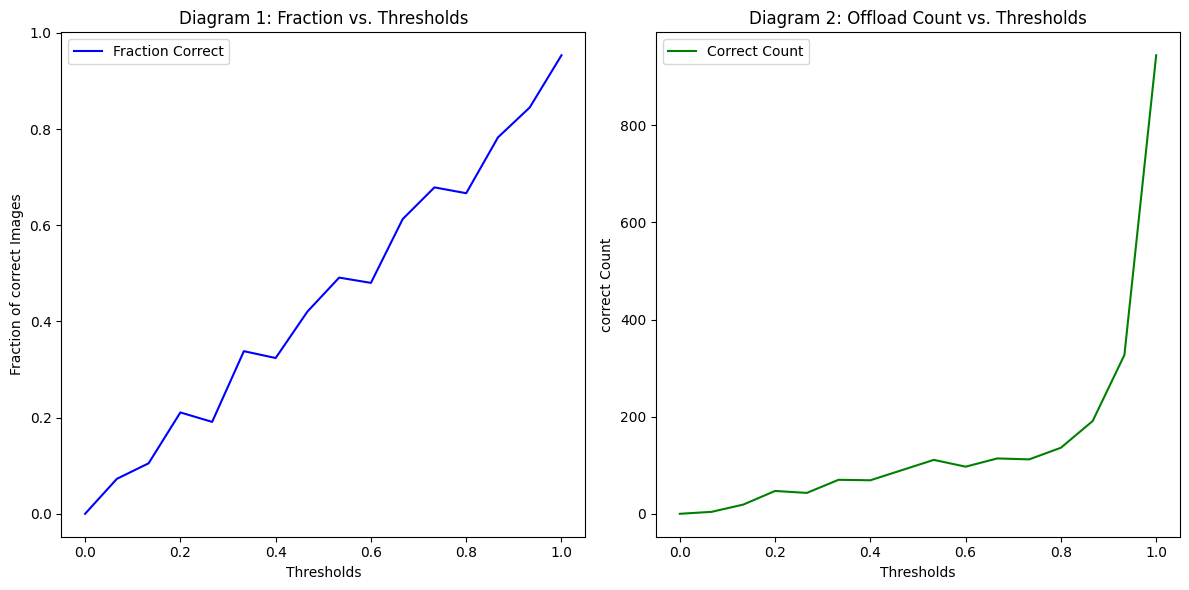

In [20]:
# import matplotlib.pyplot as plt
# fraction_correct = {threshold: correct_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plotting on the first diagram
# ax1.plot(thresholds, [fraction_correct[t] for t in thresholds], label='Fraction Correct', color='blue')
# ax1.set_xlabel('Thresholds')
# ax1.set_ylabel('Fraction of correct Images')
# ax1.set_title('Diagram 1: Fraction vs. Thresholds')
# ax1.legend()

# # Plotting on the second diagram (modify as needed)
# ax2.plot(thresholds, [correct_count[t] for t in thresholds], label='Correct Count', color='green')
# ax2.set_xlabel('Thresholds')
# ax2.set_ylabel('correct Count')
# ax2.set_title('Diagram 2: Offload Count vs. Thresholds')
# ax2.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()

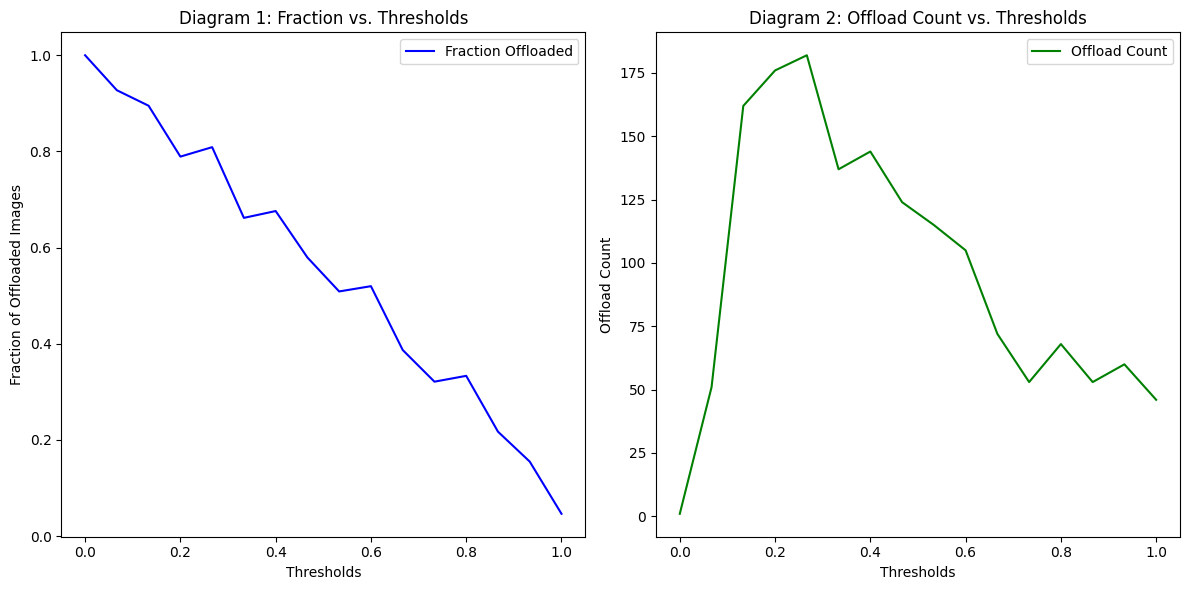

In [21]:
# import matplotlib.pyplot as plt
# fraction_offloaded = {threshold: offload_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plotting on the first diagram
# ax1.plot(thresholds, [fraction_offloaded[t] for t in thresholds], label='Fraction Offloaded', color='blue')
# ax1.set_xlabel('Thresholds')
# ax1.set_ylabel('Fraction of Offloaded Images')
# ax1.set_title('Diagram 1: Fraction vs. Thresholds')
# ax1.legend()

# # Plotting on the second diagram (modify as needed)
# ax2.plot(thresholds, [offload_count[t] for t in thresholds], label='Offload Count', color='green')
# ax2.set_xlabel('Thresholds')
# ax2.set_ylabel('Offload Count')
# ax2.set_title('Diagram 2: Offload Count vs. Thresholds')
# ax2.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()

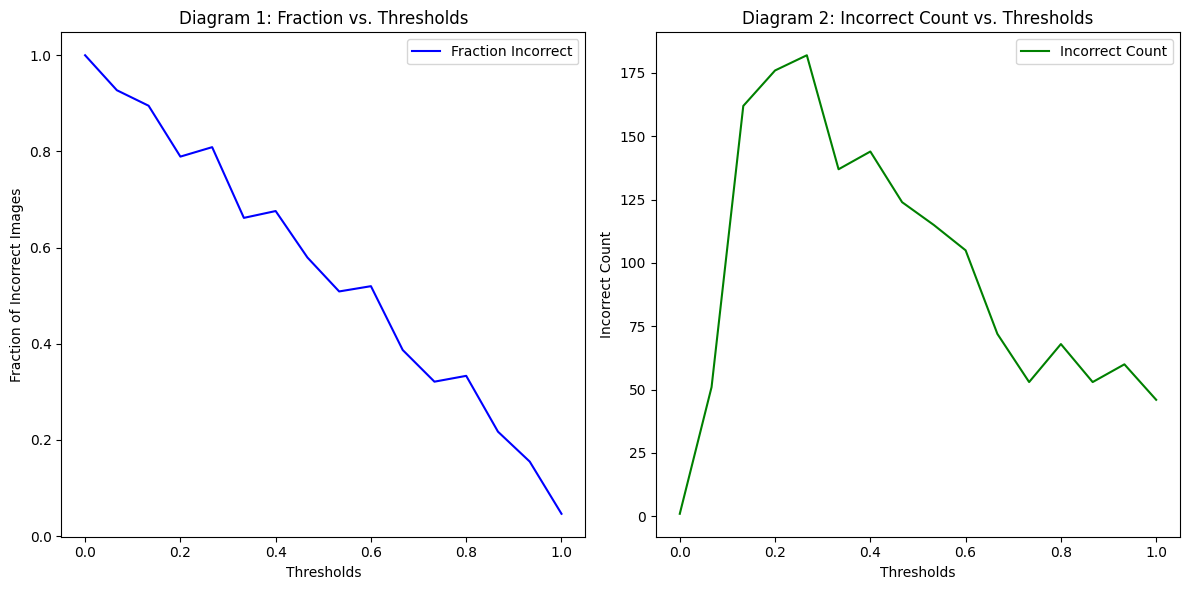

In [22]:
# import matplotlib.pyplot as plt
# fraction_incorrect = {threshold: incorrect_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plotting on the first diagram
# ax1.plot(thresholds, [fraction_incorrect[t] for t in thresholds], label='Fraction Incorrect', color='blue')
# ax1.set_xlabel('Thresholds')
# ax1.set_ylabel('Fraction of Incorrect Images')
# ax1.set_title('Diagram 1: Fraction vs. Thresholds')
# ax1.legend()

# # Plotting on the second diagram (modify as needed)
# ax2.plot(thresholds, [incorrect_count[t] for t in thresholds], label='Incorrect Count', color='green')
# ax2.set_xlabel('Thresholds')
# ax2.set_ylabel('Incorrect Count')
# ax2.set_title('Diagram 2: Incorrect Count vs. Thresholds')
# ax2.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()

In [2]:
alpha = 0.4  # Fixed alpha value
delta = 1 / math.e

# Initialize regret tracker
regret_list_LCB_UCB = []
regret_list_LCB_UCB_normalized = []

# Initialize variables to track total cost for both algorithms
cost_LCB_UCB = 0.0
cost_offline_optimal = 0.0

# Dictionaries to track UCB, LCB, Tx, Fx for LCB-UCB
dict = {
    'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
    'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
    'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
    'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
}

correct_counts = {threshold: 0 for threshold in thresholds}
offloads_counts = {threshold: 0 for threshold in thresholds}
total_counts = {threshold: 0 for threshold in thresholds}

# Process each batch of images
with torch.no_grad():
    image_count = 1

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_counts[pred_probs] += 1

        # ----- LCB-UCB Algorithm -----
        if dict['LCB'][pred_probs] >= (1 - alpha):
            if pred_class != true_class:
                cost_LCB_UCB += 1  # Increment LCB-UCB cost for incorrect prediction

        elif dict['UCB'][pred_probs] <= (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        log_delta = math.log(1 / delta)
        uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

        dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
        dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

        # Update bounds for each threshold
        for x1 in thresholds:
            if x1 <= pred_probs:
                for x in thresholds:
                    if x1 <= x <= pred_probs:
                        dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

        for x2 in thresholds:
            if x2 >= pred_probs:
                for x in thresholds:
                    if x2 >= x >= pred_probs:
                        dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

        # ----- Offline Optimal Algorithm -----
        if pred_class != true_class:
            cost_offline_optimal += alpha  # Increment offline optimal cost for incorrect prediction

        # Track cumulative costs
#         cumulative_cost_LCB_UCB.append(cost_LCB_UCB)
#         cumulative_cost_offline_optimal.append(cost_offline_optimal)

        # Compute regret at this step
        regret = cost_LCB_UCB - cost_offline_optimal
        regret_list_LCB_UCB.append(regret)
        regret_list_LCB_UCB_normalized.append(regret/image_count)

        # Increment image count for x-axis in the plot
        image_count += 1


In [3]:
regret_list_hedge =[]
regret_list_hedge_normalized =[]

cost_hedge = 0.0
cost_offline_optimal = 0.0

image_count = 1

def choose_threshold(weights, thresholds, W_t):
    # Create probability distribution for selecting a threshold
    probabilities = np.array([weights[theta] / W_t for theta in thresholds])
    
    # Choose a threshold based on the weight distribution
    chosen_threshold_idx = np.random.choice(len(thresholds), p=probabilities)
    chosen_threshold = thresholds[chosen_threshold_idx]
    
    return chosen_threshold

alpha = 0.4
# Iterate over different values of alpha
η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

cost_hedge = 0.0
weights = {threshold: 1.0 for threshold in thresholds}  # Initialize weights for each threshold
W_t = sum(weights.values())  # Sum the initial weights to get W_t
# incorrect_count = {threshold: 0 for threshold in thresholds}
# correct_count = {threshold: 0 for threshold in thresholds}
# offload_count = {threshold: 0 for threshold in thresholds}
# total_count = {threshold: 0 for threshold in thresholds}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        p_t = round(predicted_probs.item(), 4)

        pred_class = predicted_labels.item()
        true_class = labels.item()

        # Choose a threshold based on the current weights
        chosen_threshold = choose_threshold(weights, thresholds, W_t)

#         total_count[p_t] += 1

        if p_t < chosen_threshold:
            offload_count[p_t] += 1
            cost_hedge += alpha  # Offload, cost is alpha
        else:
            if pred_class != true_class:
                incorrect_count[p_t] += 1
                cost_hedge += 1  # Incorrect prediction, full cost
            else:
                correct_count[p_t] += 1

        # Compute pseudo-loss and update weights
        if pred_class == true_class:
            Y_t = 0
        else:
            Y_t = 1
            cost_offline_optimal += alpha

        for threshold in thresholds:
            if p_t < threshold:
                pseudo_loss = alpha  # Offload cost
            else:
                pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Loss depends on epsilon

            # Update the weight for the current threshold
            weights[threshold] = weights[threshold] * np.exp(-η * pseudo_loss)

        # Recalculate W_t as the sum of all updated weights
        W_t = sum(weights.values())
        
        regret = cost_hedge - cost_offline_optimal
        regret_list_hedge.append(regret)
        regret_list_hedge_normalized.append(regret/image_count)
        
        image_count += 1


In [4]:
alpha = 0.4  # Fixed alpha value
delta = 1 / math.e

# Initialize regret tracker
regret_list_LCB_UCB_no_info = []
regret_list_LCB_UCB_no_info_normalized = []

# Initialize variables to track total cost for both algorithms
cost_LCB_UCB = 0.0
cost_offline_optimal = 0.0

# Dictionaries to track UCB, LCB, Tx, Fx for LCB-UCB
dict = {
    'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
    'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
    'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
    'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
}

correct_counts = {threshold: 0 for threshold in thresholds}
offloads_counts = {threshold: 0 for threshold in thresholds}
total_counts = {threshold: 0 for threshold in thresholds}

# Process each batch of images
with torch.no_grad():
    image_count = 1

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_counts[pred_probs] += 1

        # ----- LCB-UCB Algorithm -----
        if dict['LCB'][pred_probs] >= (1 - alpha):
            if pred_class != true_class:
                cost_LCB_UCB += 1  # Increment LCB-UCB cost for incorrect prediction

        elif dict['UCB'][pred_probs] <= (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        log_delta = math.log(1 / delta)
        uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

        dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
        dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

        # ----- Offline Optimal Algorithm -----
        if pred_class != true_class:
            cost_offline_optimal += alpha  # Increment offline optimal cost for incorrect prediction

        # Compute regret at this step
        regret = cost_LCB_UCB - cost_offline_optimal
        regret_list_LCB_UCB_no_info.append(regret)
        regret_list_LCB_UCB_no_info_normalized.append(regret/image_count)

        # Increment image count for x-axis in the plot
        image_count += 1


In [7]:
alpha = 0.4  # Fixed alpha value
delta = 1 / math.e

# Initialize regret tracker
regret_list_LCB_UCBh = []
regret_list_LCB_UCB_normalizedh = []

# Initialize variables to track total cost for both algorithms
cost_LCB_UCB = 0.0
cost_offline_optimal = 0.0

# Dictionaries to track UCB, LCB, Tx, Fx for LCB-UCB
dict = {
    'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
    'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
    'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
    'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
}

correct_counts = {threshold: 0 for threshold in thresholds}
offloads_counts = {threshold: 0 for threshold in thresholds}
total_counts = {threshold: 0 for threshold in thresholds}

# Process each batch of images
with torch.no_grad():
    image_count = 1

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_counts[pred_probs] += 1

        # ----- LCB-UCB Algorithm -----
        if dict['LCB'][pred_probs] >= (1 - alpha):
            if pred_class != true_class:
                cost_LCB_UCB += 1  # Increment LCB-UCB cost for incorrect prediction

        elif dict['UCB'][pred_probs] <= (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        log_delta = math.log(1 / delta)
        uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

        dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
        dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

        eta = max(0.2, min(0.25, uncertainty))  # Dynamically adjust epsilon

        for x1 in thresholds:
            if x1 <= pred_probs:
                for x in thresholds:
                    if x1 <= x and x <= pred_probs:
                        if uncertainty < eta:
                            dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

        for x2 in thresholds:
            if x2 >= pred_probs:
                for x in thresholds:
                    if x2 >= x and x >= pred_probs:
                        if uncertainty < eta:
                            dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

        # ----- Offline Optimal Algorithm -----
        if pred_class != true_class:
            cost_offline_optimal += alpha  # Increment offline optimal cost for incorrect prediction

        # Track cumulative costs
#         cumulative_cost_LCB_UCB.append(cost_LCB_UCB)
#         cumulative_cost_offline_optimal.append(cost_offline_optimal)

        # Compute regret at this step
        regret = cost_LCB_UCB - cost_offline_optimal
        regret_list_LCB_UCBh.append(regret)
        regret_list_LCB_UCB_normalizedh.append(regret/image_count)

        # Increment image count for x-axis in the plot
        image_count += 1


In [6]:
# alpha = 0.6

# cost_Loss_LCB = 0.0
# cost_offline_optimal = 0.0

# regret_list_Loss_LCB = []
# regret_list_Loss_LCB_normalized = []

# loss_hat = {threshold: 0.0 for threshold in thresholds}

# η = 0.02 / alpha**(1/3)
# ε = min(1, math.sqrt(η / (2 * alpha)))

# image_count = 1

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         softmax_probs = F.softmax(outputs, dim=1)

#         quantized_probs = quantize_to_8bit(softmax_probs)

#         predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#         pred_probs = round(predicted_probs.item(), 4)
#         pred_class = predicted_labels.item()
#         true_class = labels.item()

#         best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t] - math.log(math.e / (T_x[t] + 1e-8))))

#         if pred_probs < best_threshold:
#             cost_Loss_LCB += alpha  # Offload, cost is alpha
#         else:
#             if pred_class != true_class:
#                 cost_Loss_LCB += 1  # Incorrect prediction, full cost

#         Y_t = 0 if pred_class == true_class else 1

#         for threshold in thresholds:
#             if pred_probs < threshold:
#                 pseudo_loss = alpha  # Offload cost
#             else:
#                 pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

#             loss_hat[threshold] += pseudo_loss
            
#         if pred_class != true_class:
#             cost_offline_optimal += alpha
        
#         regret = cost_Loss_LCB - cost_offline_optimal
#         regret_list_Loss_LCB.append(regret)
#         regret_list_Loss_LCB_normalized.append(regret/image_count)

#         image_count += 1


In [11]:
# alpha = 0.6

# cost_Loss = 0.0
# cost_offline_optimal = 0.0

# regret_list_Loss = []
# regret_list_Loss_normalized = []

# loss_hat = {threshold: 0.0 for threshold in thresholds}

# η = 0.02 / alpha**(1/3)
# ε = min(1, math.sqrt(η / (2 * alpha)))

# image_count = 1

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         softmax_probs = F.softmax(outputs, dim=1)

#         quantized_probs = quantize_to_8bit(softmax_probs)

#         predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#         pred_probs = round(predicted_probs.item(), 4)
#         pred_class = predicted_labels.item()
#         true_class = labels.item()

#         best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t]))

#         if pred_probs < best_threshold:
#             cost_Loss_LCB += alpha  # Offload, cost is alpha
#         else:
#             if pred_class != true_class:
#                 cost_Loss_LCB += 1  # Incorrect prediction, full cost

#         Y_t = 0 if pred_class == true_class else 1

#         for threshold in thresholds:
#             if pred_probs < threshold:
#                 pseudo_loss = alpha  # Offload cost
#             else:
#                 pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

#             loss_hat[threshold] += pseudo_loss
            
#         if pred_class != true_class:
#             cost_offline_optimal += alpha
        
#         regret = - cost_Loss + cost_offline_optimal
#         regret_list_Loss.append(regret)
#         regret_list_Loss_normalized.append(regret/image_count)

#         image_count += 1


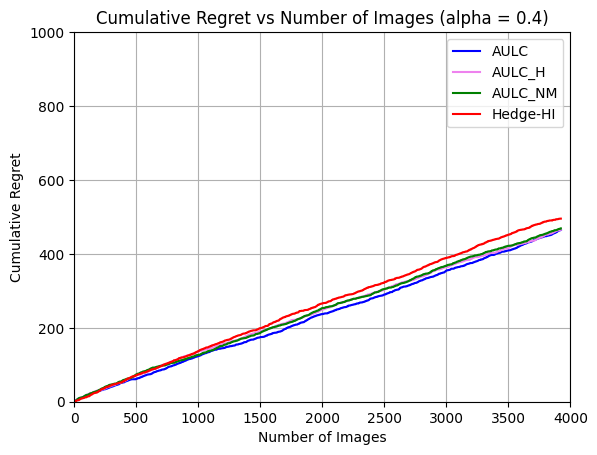

In [8]:
import matplotlib.pyplot as plt

# Your existing plot code
plt.plot(range(1, image_count), regret_list_LCB_UCB, label='AULC', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCBh, label='AULC_H', color='violet')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info, label='AULC_NM', color='g')
plt.plot(range(1, image_count), regret_list_hedge, label='Hedge-HI', color='r')
# plt.plot(range(1, image_count), regret_list_Loss_LCB, label='Loss_LCB', color='brown')
# plt.plot(range(1, image_count), regret_list_Loss, label='Loss', color='violet')

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret vs Number of Images (alpha = 0.4)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Set limits for both axes to scale of 500
plt.xlim(0, 4000)
plt.ylim(0, 1000)

# Show the plot
plt.show()


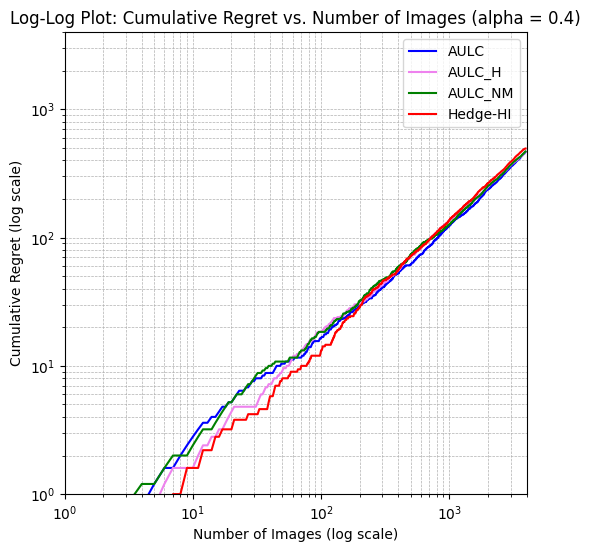

In [11]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(6, 6))  # Make the figure square

# Plot regret curves
plt.plot(range(1, image_count), regret_list_LCB_UCB, label='AULC', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCBh, label='AULC_H', color='violet')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info, label='AULC_NM', color='g')
plt.plot(range(1, image_count), regret_list_hedge, label='Hedge-HI', color='r')

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Set limits to ensure same range on both axes
plt.xlim(1, 4000)
plt.ylim(1, 4000)  # Match x-axis scale

# Ensure equal aspect ratio
plt.gca().set_box_aspect(1)  # Keeps plot square

# Labels, title, and legend
plt.xlabel('Number of Images (log scale)')
plt.ylabel('Cumulative Regret (log scale)')
plt.title('Log-Log Plot: Cumulative Regret vs. Number of Images (alpha = 0.4)')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()


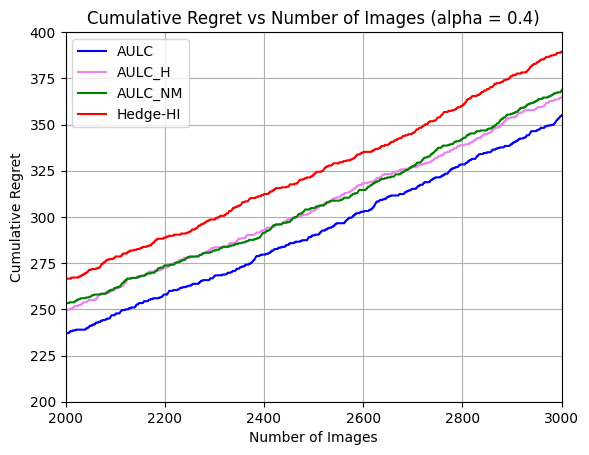

In [9]:
import matplotlib.pyplot as plt

# Your existing plot code
plt.plot(range(1, image_count), regret_list_LCB_UCB, label='AULC', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCBh, label='AULC_H', color='violet')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info, label='AULC_NM', color='g')
plt.plot(range(1, image_count), regret_list_hedge, label='Hedge-HI', color='r')
# plt.plot(range(1, image_count), regret_list_Loss_LCB, label='Loss_LCB', color='brown')
# plt.plot(range(1, image_count), regret_list_Loss, label='Loss', color='violet')

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret vs Number of Images (alpha = 0.4)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Set limits for both axes to scale of 500
plt.xlim(2000, 3000)
plt.ylim(200, 400)

# Show the plot
plt.show()


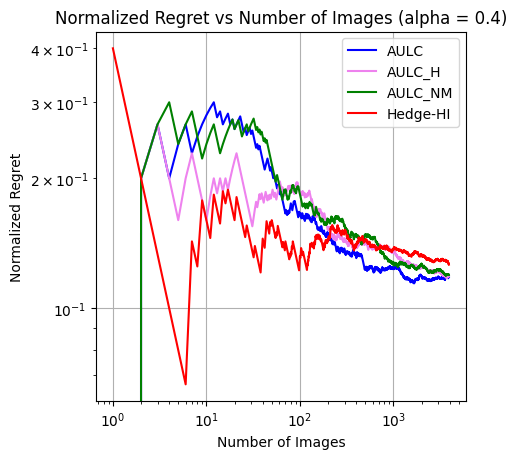

In [14]:
# Plotting cumulative regret for all three algorithms in the same graph
plt.plot(range(1, image_count), regret_list_LCB_UCB_normalized, label='AULC', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCB_normalizedh, label='AULC_H', color='violet')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info_normalized, label='AULC_NM', color='g')
plt.plot(range(1, image_count), regret_list_hedge_normalized, label='Hedge-HI', color='r')
# plt.plot(range(1, image_count), regret_list_Loss_LCB_normalized, label='Loss_LCB', color='brown')
# plt.plot(range(1, image_count), regret_list_Loss_normalized, label='Loss', color='violet')

plt.xscale('log')
plt.yscale('log')

plt.gca().set_box_aspect(1)  # Keeps plot square

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Normalized Regret')
plt.title('Normalized Regret vs Number of Images (alpha = 0.4)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Set log-log scale


# plt.xlim(1, 4000)
# plt.ylim(1, 4000)  # Match x-axis scale



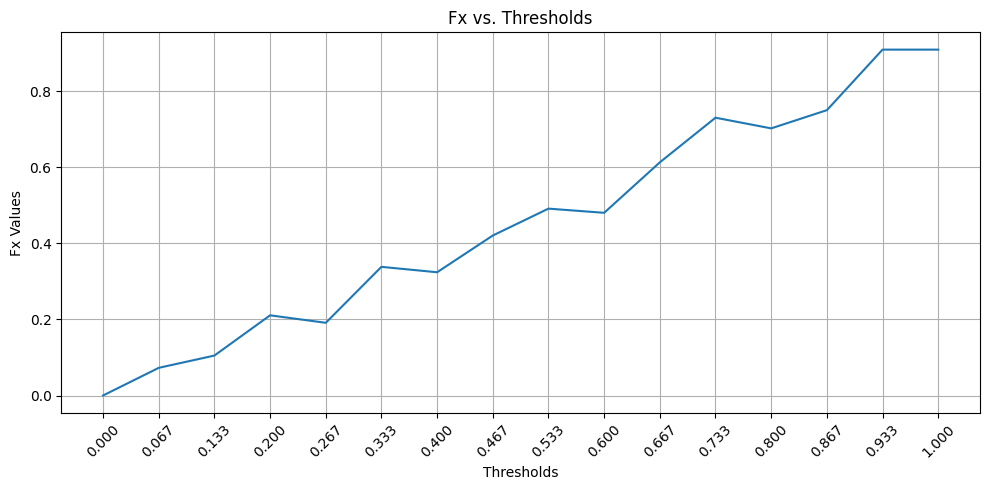

In [15]:
import matplotlib.pyplot as plt

# Assuming you already have `thresholds` and `dict['Fx']` populated

# Prepare data for plotting
threshold_values = list(thresholds)
fx_values = [dict['Fx'][threshold] for threshold in thresholds]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(threshold_values, fx_values)
plt.title('Fx vs. Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Fx Values')
plt.xticks(threshold_values, rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to make room for labels
plt.show()


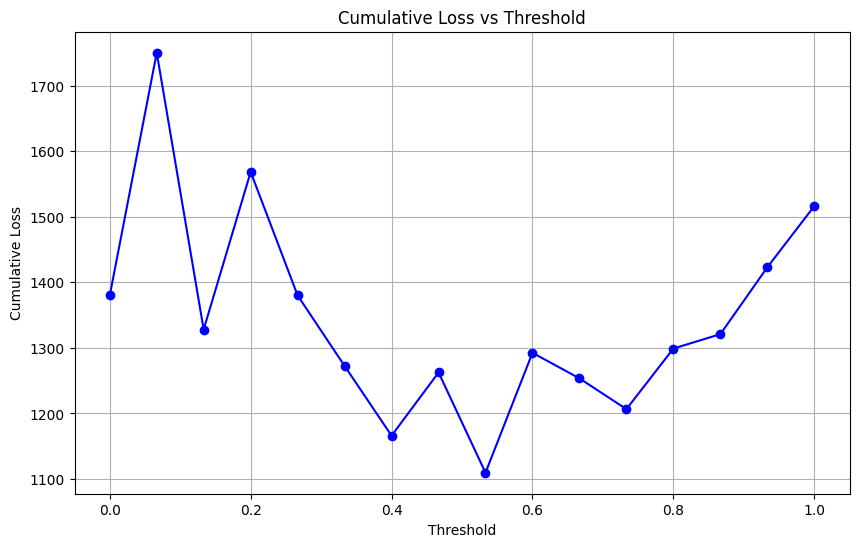

In [32]:
# loss = {threshold: 0.0 for threshold in thresholds}
# image_count = 1  # Initialize image count
# alpha = 0.5
# ε = 0.1

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         # Get model outputs and softmax probabilities
#         outputs = model(images)
#         softmax_probs = F.softmax(outputs, dim=1)

#         # Quantize probabilities to 8-bit
#         quantized_probs = quantize_to_8bit(softmax_probs)

#         # Get the predicted probabilities and classes
#         predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#         pred_probs = round(predicted_probs.item(), 4)
#         pred_class = predicted_labels.item()
#         true_class = labels.item()

#         # Check if prediction is correct
#         Y_t = 0 if pred_class == true_class else 1

#         # Update loss for each threshold
#         for threshold in thresholds:
#             if pred_probs < threshold:
#                 loss[threshold] += alpha  # Offload cost
#             else:
#                 loss[threshold] += Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

#         image_count += 1

# # Plotting Loss vs Threshold
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, list(loss.values()), marker='o', color='b')
# plt.xlabel('Threshold')
# plt.ylabel('Cumulative Loss')
# plt.title('Cumulative Loss vs Threshold')
# plt.grid(True)
# plt.show()


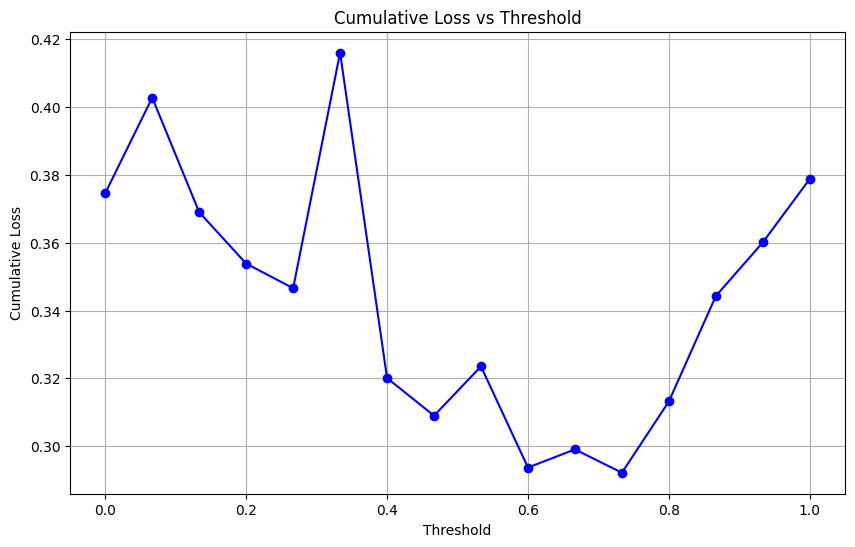

In [33]:
# loss = {threshold: 0.0 for threshold in thresholds}
# image_count = 1  # Initialize image count
# alpha = 0.5
# ε = 0.1

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         # Get model outputs and softmax probabilities
#         outputs = model(images)
#         softmax_probs = F.softmax(outputs, dim=1)

#         # Quantize probabilities to 8-bit
#         quantized_probs = quantize_to_8bit(softmax_probs)

#         # Get the predicted probabilities and classes
#         predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
#         pred_probs = round(predicted_probs.item(), 4)
#         pred_class = predicted_labels.item()
#         true_class = labels.item()

#         # Check if prediction is correct
#         Y_t = 0 if pred_class == true_class else 1

#         # Update loss for each threshold
#         for threshold in thresholds:
#             if pred_probs < threshold:
#                 loss[threshold] = (loss[threshold]*image_count + alpha)/(image_count+1)  # Offload cost
#             else:
#                 pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon
#                 loss[threshold] = (loss[threshold]*image_count + pseudo_loss)/(image_count+1)

#         image_count += 1

# # Plotting Loss vs Threshold
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, list(loss.values()), marker='o', color='b')
# plt.xlabel('Threshold')
# plt.ylabel('Cumulative Loss')
# plt.title('Cumulative Loss vs Threshold')
# plt.grid(True)
# plt.show()


In [3]:
# correct = 0
# incorrect = 0
# total = 0

# correct_counts = {threshold: 0 for threshold in thresholds}
# total_counts = {threshold: 0 for threshold in thresholds}

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Get model outputs and softmax probabilities
#         outputs = model(images)
#         softmax_probs = F.softmax(outputs, dim=1)
        
#         # Get predicted classes and their associated probabilities
#         predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

#         # Check which predictions are correct
#         correct_predictions = (predicted_labels == labels)
#         if(predicted_labels == labels):
#             correct_count[pred_probs] += 1
#         total_count[pred_probs] += 1

# print(total_counts)
# print(correct_counts)

{0.0: 0, 0.0667: 0, 0.1333: 0, 0.2: 0, 0.2667: 0, 0.3333: 0, 0.4: 0, 0.4667: 0, 0.5333: 0, 0.6: 0, 0.6667: 0, 0.7333: 0, 0.8: 0, 0.8667: 0, 0.9333: 0, 1.0: 0}
{0.0: 0, 0.0667: 0, 0.1333: 0, 0.2: 0, 0.2667: 0, 0.3333: 0, 0.4: 0, 0.4667: 0, 0.5333: 0, 0.6: 0, 0.6667: 0, 0.7333: 0, 0.8: 0, 0.8667: 0, 0.9333: 0, 1.0: 0}
